In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 5

# 入力長

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1097 (4.29 KB)
Trainable params: 1097 (4.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


18/26 [===================>..........] - ETA: 0s - loss: 1.6041 - accuracy: 0.4392 
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
26/26 [==============================] - 2s 25ms/step - loss: 1.5974 - accuracy: 0.4599 - val_loss: 1.5581 - val_accuracy: 0.6130
Epoch 2/1000
19/26 [====================>.........] - ETA: 0s - loss: 1.5477 - accuracy: 0.5744

c:\Users\joris\miniconda3\envs\p39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
26/26 [==============================] - 0s 8ms/step - loss: 1.5441 - accuracy: 0.5667 - val_loss: 1.5009 - val_accuracy: 0.6269
Epoch 3/1000
15/26 [================>.............] - ETA: 0s - loss: 1.5028 - accuracy: 0.5771
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
26/26 [==============================] - 0s 7ms/step - loss: 1.4917 - accuracy: 0.5744 - val_loss: 1.4337 - val_accuracy: 0.6380
Epoch 4/1000
22/26 [========================>.....] - ETA: 0s - loss: 1.4334 - accuracy: 0.5781
Epoch 4: saving model to model/point_history_classifier\point_history_classifier.hdf5
26/26 [==============================] - 0s 8ms/step - loss: 1.4304 - accuracy: 0.5719 - val_loss: 1.3512 - val_accuracy: 0.6481
Epoch 5/1000
23/26 [=========================>....] - ETA: 0s - loss: 1.3534 - accuracy: 0.5938
Epoch 5: saving model to model/point_history_classifier\point_hist

In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 229ms/step
[9.6994430e-01 1.3247871e-02 1.5758816e-02 4.7847457e-04 5.7047547e-04]
0


# 混同行列

34/34 [==============================] - 0s 2ms/step


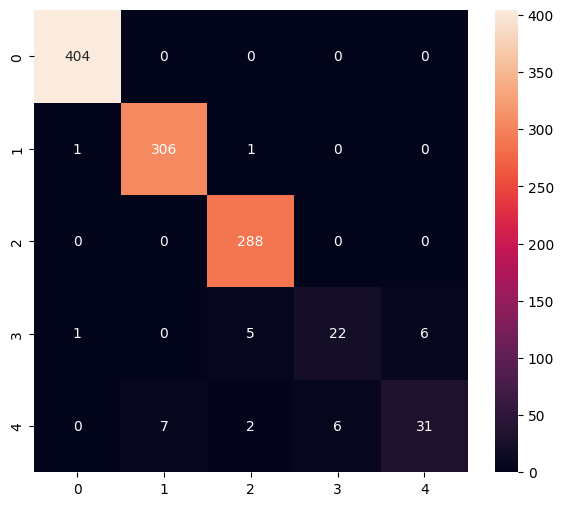

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       0.98      0.99      0.99       308
           2       0.97      1.00      0.99       288
           3       0.79      0.65      0.71        34
           4       0.84      0.67      0.75        46

    accuracy                           0.97      1080
   macro avg       0.91      0.86      0.89      1080
weighted avg       0.97      0.97      0.97      1080



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

c:\Users\joris\miniconda3\envs\p39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [18]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

In [19]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [20]:
tflite_quantized_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk4ofp1sb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk4ofp1sb\assets


In [21]:
open(tflite_save_path, 'wb').write(tflite_quantized_model)

6476

# 推論テスト

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.6994430e-01 1.3247864e-02 1.5758799e-02 4.7847434e-04 5.7047547e-04]
0
